# Mine management model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demddp03.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

A mine operator must decide how much ore to extract from a mine that will be shut down and abandoned after $T$ years of operation. The price of extracted ore is $p$ dollars per ton, and the total cost of extracting $x$ tons of ore in any year, given that the mine contains $s$ tons at the beginning of the year, is $c(s, x)$ dollars. The mine currently contains $\bar{s}$ tons of ore. Assuming the amount of ore extracted in any year must be an integer number of tons, what extraction schedule maximizes profits?

## Initial tasks


In [1]:
import numpy as np
import pandas as pd
from compecon import DDPmodel, getindex

## Model Parameters

Assuming a market price $p=1$, initial stock of ore $\bar{s}=100$, and annual discount factor $\delta = 0.9$

In [2]:
price = 1
sbar  = 100
delta = 0.9

### State Space

This is a finite horizon, deterministic model with time $t$ measured in years. The state
variable $s \in \{0, 1, 2, \dots, \bar{s}\}$ is the amount of ore remaining in the mine at the beginning of the year, measured in tons.

In [3]:
S = np.arange(sbar + 1)      # vector of states
n = S.size                   # number of states

### Action Space

The action variable $x \in \{0, 1, 2, \dots, s\}$ is the amount of ore extracted over the year, measured in tons.

In [4]:
X = np.arange(sbar + 1)      # vector of actions
m = X.size                   # number of actions

### Reward Function

The reward function is $f(s, x) = px − c(s, x)$. The cost of extraction is $c(s, x) = \frac{x^2}{1+s}$.

Here, the reward is set to negative infinity if the extraction level exceeds the available stock in order to preclude the choice of an infeasible
action:

In [5]:
f = np.full((m, n), -np.inf)
for c, s in enumerate(S):
    for r, x in enumerate(X):
        if x <= s:
            f[r, c] = price * x - (x ** 2) / (1 + s)

### State Transition Function

The state transition function is $g(s, x) = s − x$

Here, the routine `getindex` is used to find the index of the following period’s state.

In [6]:
g = np.empty_like(f)
for r, x in enumerate(X):
    snext = S - x
    g[r] = getindex(snext, S)

## Model Structure

The value of the mine, given that it contains $s$ tons of ore at the beginning of year $t$, satisfies the Bellman equation

\begin{equation} V_t(s) = max_{x\in\{0,1,\dots,s\}} \left\{px−c(s, x) + \delta V_{t+1}(s−x)\right\} \end{equation}

subject to the terminal condition $V_{T+1}(s) = 0$

To solve and simulate this model, use the CompEcon class ```DDPmodel```. 

In [7]:
model = DDPmodel(f, g, delta)
model.solve()

A deterministic discrete state, discrete action, dynamic model.
There are 101 possible actions over 101 possible states

By default, the `solve()` method uses Newton's algorithm. This and other default settings can be changed when solving the model. For example,
```python
model.solve(algorithm='funcit', print=True)
```
solves the model by function iteration, printing a summary of each iteration to screen.

In either case, `solve()` updates the model itself, storing the $n$ vector of values `.value`, the $n$ vector of optimal actions `.policy`, and the $n\times n$ controlled state `.transition` probability.


In [8]:
solution = pd.DataFrame({
    'Stock': S,
    'Extraction': X[model.policy], 
    'Value': model.value}).set_index('Stock')

## Analysis

### Simulate Model
The path followed by the stock level over time is computed by the `simulate()` method. Here, the simulation assumes an initial stock level of 100 and 15 years in duration.

In [9]:
sinit = S.max()
nyrs = 15
t = np.arange(nyrs + 1)
spath, xpath = model.simulate(sinit, nyrs)

simul = pd.DataFrame({
    'Year': t,
    'Stock': S[spath],
    'Extraction': X[xpath]}).set_index('Year')
simul

,Stock,Extraction
Year,,
0,100,24
1,76,18
2,58,14
3,44,11
4,33,8
5,25,6
6,19,5
7,14,3
8,11,3


### Plot Optimal Policy

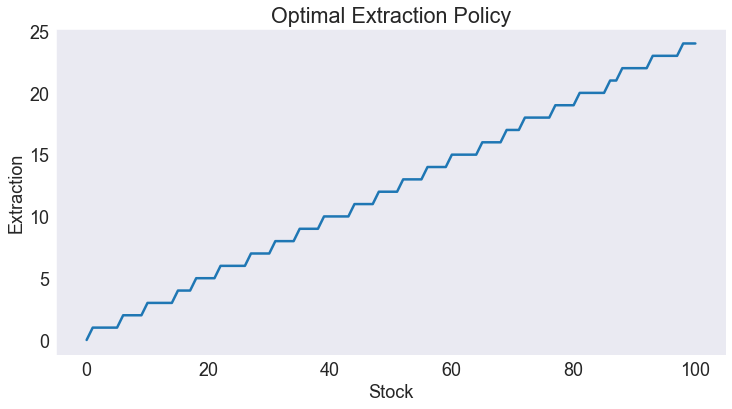

In [10]:
ax = solution['Extraction'].plot(title='Optimal Extraction Policy')
ax.set(ylabel='Extraction');

### Plot Value Function
The value of the firm is very nearly proportional to the stock level.

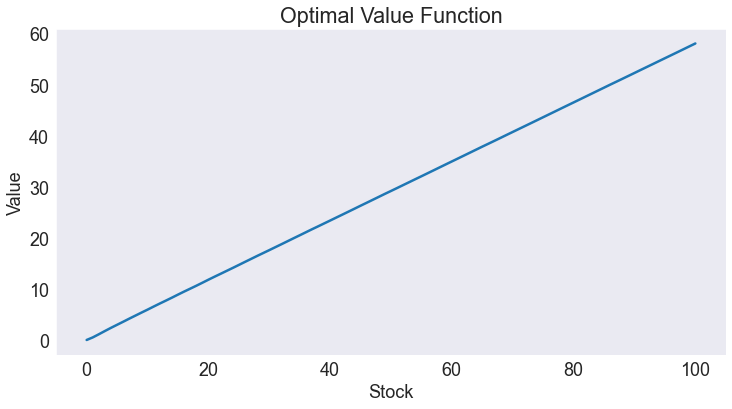

In [11]:
ax = solution['Value'].plot(title='Optimal Value Function')
ax.set(ylabel='Value');

### Plot State and Extraction Path
As seen in this figure, the content of the mine is optimally exhausted in 15 years.

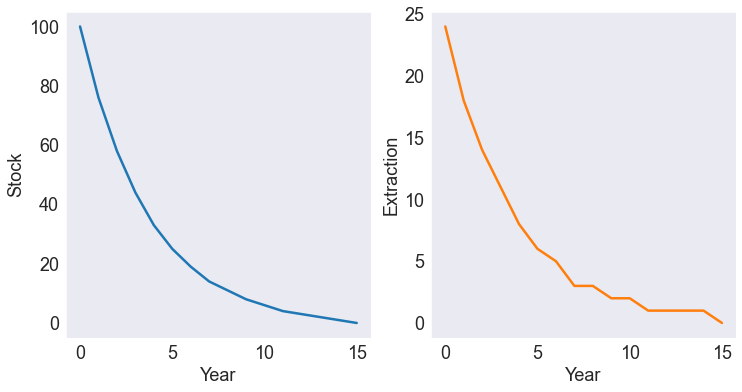

In [12]:
ax = simul.plot(subplots=True, layout=[1,2], legend=None)
for i, lab in enumerate(simul.columns):
    ax[0, i].set(ylabel=lab);